Brain Tumor Classifier

In [2]:
# import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,utils,models,datasets
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import imutils
import os, random
import os.path
import platform

print("python version:", platform.python_version())
print("torch version:", torch.__version__)
print("torch cuda:", torch.cuda.is_available())
print("torch cuda version", torch.version.cuda)
gpu=torch.device('cuda:0')

python version: 3.7.7
torch version: 1.6.0
torch cuda: True
torch cuda version 10.2


In [3]:
# the model
model = models.vgg16(pretrained=True)

for param in model.features.parameters():
    param.requires_grad=False

gap = nn.AdaptiveAvgPool2d((1, 1))
first_fc_layer=nn.Linear(512, 1024)
second_fc_layer=nn.Linear(1024, 1024)
last_fc_layer=nn.Linear(1024, 2)
do1=torch.nn.Dropout(p=0, inplace=False)
do2=torch.nn.Dropout(p=0, inplace=False)

model.avgpool = gap
model.classifier[0]=first_fc_layer
model.classifier[3]=second_fc_layer
model.classifier[6]=last_fc_layer
model.classifier[2]=do1
model.classifier[5]=do2

model.to(gpu)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
# load trained model
checkpoint = torch.load(r'checkpoint/vgg16_lowest_val_loss_epoch_20.pth')
model.load_state_dict(checkpoint['state_dict'])
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
# prepare test data
transform=transforms.Compose([
    transforms.Resize((224 ,224))
    ,transforms.ToTensor()
    ,transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_data=datasets.ImageFolder(
    root='dataset/test_set/'
    ,transform=transform
)

test_loader=torch.utils.data.DataLoader(
    test_data,
    batch_size=32
    ,shuffle=False
    ,num_workers=1
    ,pin_memory=True
)

print("Classes : ", test_data.class_to_idx)
print("Number of Test Samples : ", len(test_data))

Classes :  {'Negative': 0, 'Positive': 1}
Number of Test Samples :  20


In [6]:
all_preds = torch.tensor([])
all_preds = all_preds.to(gpu)

for batch in test_loader:
    images, labels = batch
    images = images.to(gpu)
    labels = labels.to(gpu)

    # predict
    model.eval()
    with torch.no_grad():
        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
            )

all_preds = all_preds.cpu()
test_preds_indices = all_preds.argmax(dim=1).cpu()
test_act_labels = torch.tensor(test_data.targets)

print(test_preds_indices)
print(test_act_labels)

tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [7]:
# confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cnf_matrix = confusion_matrix(test_act_labels, test_preds_indices.cpu())
print(cnf_matrix)

[[8 2]
 [3 7]]


Text(0.5, 17.5, 'Predicted label')

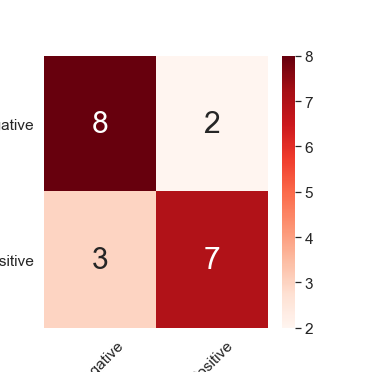

In [8]:
# plot confusion matrix with seaborn
import seaborn as sns
plt.figure(figsize=(5,5))

x_axis_labels = ['Negative', 'Positive']
y_axis_labels = ['Negative', 'Positive']

sns.set(font_scale=1.4)#for label size
sns.heatmap(cnf_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, annot_kws={"size": 30} , cmap="Reds", fmt='g')

plt.yticks(rotation=360)
plt.xticks(rotation=45)

plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig(r'graphs\cnf.png', dpi = 100)

In [9]:
# create label for data (per each class), for calssification report
class_labels = test_data.class_to_idx
class_name = list(class_labels.keys())

# classification report
print(classification_report(test_act_labels, test_preds_indices.cpu(), target_names = class_name))

              precision    recall  f1-score   support

    Negative       0.73      0.80      0.76        10
    Positive       0.78      0.70      0.74        10

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.75      0.75      0.75        20



No Skill: ROC AUC=0.500
Model: ROC AUC=0.920


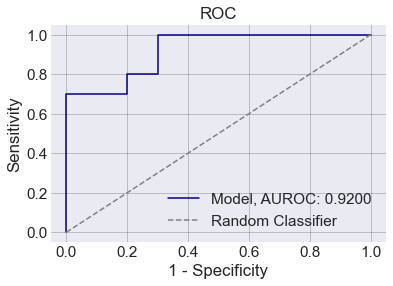

In [10]:
# roc, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

auc  = roc_auc_score(test_act_labels, test_preds_indices.cpu())
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.title('ROC')

lr_probs = all_preds.cpu()[:, 1]
testy = test_act_labels
ns_probs = [0 for _ in range(len(testy))]

ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Model: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)

plt.plot(lr_fpr, lr_tpr, label= 'Model, AUROC: %.4f' % lr_auc, color = 'navy')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Classifier', color = 'gray')

plt.ylabel('Sensitivity')
plt.xlabel('1 - Specificity')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)

plt.legend()

#plt.savefig(r'graphs\roc.png', dpi = 100)

Make Single Prediction

In [11]:
# select random image from directory
Negative = random.choice(os.listdir(r"dataset\test_set\Negative"))
Positive = random.choice(os.listdir(r"dataset\test_set\Positive"))
image_path = random.choice([Negative, Positive])

# path of image file
for root, dirs, files in os.walk(r'D:\Data\Documents\Rafi\Python Scripts\Brain_Tumor_Classifier_Model_PyTorch'):
    for name in files:
        if name == image_path:
            image_path = os.path.abspath(os.path.join(root, name))

# load image data
loadimage = image_path

# true label of the image
true_label = os.path.split(os.path.dirname(loadimage))[-1]

# function, make prediction
def testimage():
    global loadimage
    model.eval()
    with torch.no_grad():
        test_image = Image.open(loadimage).convert('RGB')
        test_image = transform(test_image).float()
        #test_image = np.transpose(test_image, (1,2,0))
        test_image = test_image.unsqueeze_(0)
        test_image = test_image.to(gpu)
        test_image = model(test_image)
        test_image = F.softmax(test_image, dim=1) * 100

        if test_image[0][0] > test_image[0][1]:
            result = 'Negative'
        else:
            result = 'Positive'
        
        Negative = test_image[0][0]
        Positive = test_image[0][1]

        return Negative, Positive, result

test_image = testimage()

def testimage_prob_sorted():
    testimage_prob_sorted = {test_image[0]: "Negative",test_image[1]: "Positive"}
    testimage_prob_sorted = {v: k for k, v in sorted(testimage_prob_sorted.items(), reverse=True)}
    return testimage_prob_sorted

testimage_prob_sorted = testimage_prob_sorted()

# extract every single key and value on testimage_prob_sorted dictionary to its own variable
testimage_prob_sorted_keys = list(testimage_prob_sorted.keys())
testimage_prob_sorted_values = list(testimage_prob_sorted.values())

prob_key_1 = testimage_prob_sorted_keys[0]
prob_value_1 = round(testimage_prob_sorted_values[0].item(),2)

prob_key_2 = testimage_prob_sorted_keys[1]
prob_value_2 = round(testimage_prob_sorted_values[1].item(),2)

# OpenCV

# Image
img = cv2.imread(loadimage)
img = cv2.resize(img, (500, 500))

# Write some Text
font                   = cv2.FONT_HERSHEY_SIMPLEX
fontScale              = 0.6
lineType               = 1

result = testimage()[2]

def fontColor():
    if true_label == result:
            fontColor  = (0, 255, 0)
    else:
        fontColor  = (0, 0, 255)
    return fontColor

fontColor = fontColor()

true_label_text_pos = (10,30)
predicted_label_text_pos = (10,60)
predicted_proba_text_pos_1 = (10,90)
predicted_proba_text_pos_2 = (10,120)
# get file name
file_name = os.path.basename(image_path)
file_name_pos = (10,150)


cv2.putText(img,'True Label : ' + true_label, 
    true_label_text_pos, 
    font, 
    fontScale,
    fontColor,
    lineType)

cv2.putText(img,'Predicted Label : ', 
    predicted_label_text_pos, 
    font, 
    fontScale,
    fontColor,
    lineType)

cv2.putText(img,prob_key_1 + " - " + str(prob_value_1) + '%', 
    predicted_proba_text_pos_1, 
    font, 
    fontScale,
    fontColor,
    lineType)

cv2.putText(img,prob_key_2 + " - " + str(prob_value_2) + '%', 
    predicted_proba_text_pos_2, 
    font, 
    fontScale,
    fontColor,
    lineType)

cv2.putText(img,'File Name : ' + file_name, 
    file_name_pos,       
    font, 
    fontScale,
    fontColor,
    lineType)

#Display the image
cv2.imshow("Brain Tumor Classifier",img)
#cv2.imwrite(r"graphs\test.png", output)
cv2.waitKey(0)
cv2.destroyAllWindows()